In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import os
import glob
import json
import csv
import sys
import numpy as np

In [5]:
!ls /hot/data/flights/*.csv | head

/hot/data/flights/flights_on_time_performance_2009_01.csv
/hot/data/flights/flights_on_time_performance_2009_02.csv
/hot/data/flights/flights_on_time_performance_2009_03.csv
/hot/data/flights/flights_on_time_performance_2009_04.csv
/hot/data/flights/flights_on_time_performance_2009_05.csv
/hot/data/flights/flights_on_time_performance_2009_06.csv
/hot/data/flights/flights_on_time_performance_2009_07.csv
/hot/data/flights/flights_on_time_performance_2009_08.csv
/hot/data/flights/flights_on_time_performance_2009_09.csv
/hot/data/flights/flights_on_time_performance_2009_10.csv


In [15]:
df = pd.read_csv('/hot/data/flights/flights_on_time_performance_2009_01.csv', nrows=10)
cleaned_columns = list(map(lambda x: x.lower(), list(df.columns)))

In [54]:
df.head()

,YEAR,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2009,1,7,1503,5.0,16.0,8.0,1623,-1.0,0.0,0.0,80.0,74.0,50.0,229.0,NaN,NaN,NaN,NaN,NaN
1,2009,1,1,1503,0.0,11.0,14.0,1623,-12.0,0.0,0.0,80.0,68.0,43.0,229.0,NaN,NaN,NaN,NaN,NaN
2,2009,1,2,1503,-12.0,10.0,16.0,1623,-23.0,0.0,0.0,80.0,69.0,43.0,229.0,NaN,NaN,NaN,NaN,NaN
3,2009,1,3,1503,-5.0,15.0,8.0,1623,-13.0,0.0,0.0,80.0,72.0,49.0,229.0,NaN,NaN,NaN,NaN,NaN
4,2009,1,4,1503,-8.0,9.0,11.0,1623,-16.0,0.0,0.0,80.0,72.0,52.0,229.0,NaN,NaN,NaN,NaN,NaN


In [16]:
output_columns = ['CarrierName', 'CarrierCode', 'FlightNumber',
                               'Day', 'Month', 'Year', 'DayOfWeek',
                               'OriginCity', 'OriginState', 'OriginAirportIATACode', 'OriginLongitude', 'OriginLatitude',
                               'OriginAltitude',
                               'DestCity', 'DestState', 'DestAirportIATACode', 'DestLongitude', 'DestLatitude', 'DestAltitude',
                               'Distance',
                               'CancellationReason', 'Cancelled', 'Diverted', 'CrsArrTime', 'CrsDepTime',
                               'ActualElapsedTime', 'AirTime', 'ArrDelay',
                               'CarrierDelay', 'CrsElapsedTime',
                               'DepDelay', 'LateAircraftDelay', 'NasDelay',
                               'SecurityDelay', 'TaxiIn', 'TaxiOut', 'WeatherDelay',
                               'AirlineYearFounded', 'AirlineYearDefunct']

In [17]:
Sfinal = set(map(lambda x: x.lower(), output_columns))

In [18]:
Sinput = set(map(lambda x: x.replace('_', ''), cleaned_columns))

In [21]:
csvinput_cols = Sinput & Sfinal

In [23]:
# indices
csvinput_cols

{'actualelapsedtime',
 'airtime',
 'arrdelay',
 'cancelled',
 'carrierdelay',
 'crsarrtime',
 'crsdeptime',
 'crselapsedtime',
 'dayofweek',
 'depdelay',
 'distance',
 'diverted',
 'lateaircraftdelay',
 'month',
 'nasdelay',
 'securitydelay',
 'taxiin',
 'taxiout',
 'weatherdelay',
 'year'}

In [26]:
normalcols = [name.replace('_', '') for name in cleaned_columns]

In [29]:
relevant_column_pairs = sorted([(name, normalcols.index(name)) for name in csvinput_cols], key=lambda x: x[1])

In [32]:
relevant_columns = [t[0] for t in relevant_column_pairs]
relevant_indices = [t[1] for t in relevant_column_pairs]
relevant_columns, relevant_indices

(['year',
  'month',
  'dayofweek',
  'crsdeptime',
  'depdelay',
  'taxiout',
  'taxiin',
  'crsarrtime',
  'arrdelay',
  'cancelled',
  'diverted',
  'crselapsedtime',
  'actualelapsedtime',
  'airtime',
  'distance',
  'carrierdelay',
  'weatherdelay',
  'nasdelay',
  'securitydelay',
  'lateaircraftdelay'],
 [0, 2, 4, 29, 31, 36, 39, 40, 42, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60])

In [33]:
# now analyze csv file! only fetch relevant columns...

In [132]:

path = '/hot/data/flights/flights_on_time_performance_2009_01.csv'
df = pd.read_csv(path, nrows=10, usecols=relevant_indices)

In [133]:
df_str = pd.read_csv(path, dtype=str, nrows=10, usecols=relevant_indices)

In [134]:
# import csv

# # want to get the fieldnames

# path = '/hot/data/flights/flights_on_time_performance_2009_01.csv'
# with open('names.csv', newline='') as csvfile:
#     reader = csv.DictReader(csvfile)

In [135]:
df_str.iloc[:, 0].str.len()

0    4
1    4
2    4
3    4
4    4
5    4
6    4
7    4
8    4
9    4
Name: YEAR, dtype: int64

In [136]:
# should parse delayed? --> do so if representation is SMALLER than smallest optimized representation that's possible.
# for each column compute statistics

# needs df, df_str

stats = []
for c in df.columns:
    stat = {'name' : c, 'type': str(df[c].dtype)}
    
    null_count = df[c].isna().count()
    stat['nullable'] = null_count > 0
    stat['nrows'] = len(df[c])
    stat['nnulls'] = null_count
    stat['cardinality'] = len(df[c].unique())
    
    # csv data from str dataframe!
    stat['csvcellmin'] = df_str[c].str.len().min()
    stat['csvcellmax'] = df_str[c].str.len().max()
    
    if stat['type'] == 'int64':
        # check min/max
        stat['imin'] = int(df[c].min())
        stat['imax'] = int(df[c].max())
        
    if stat['type'] == 'float64':
        stat['fmin'] = df[c].min()
        stat['fmax'] = df[c].max()
    
    stats.append(stat)

In [137]:
# filter specialization for each file!!!

# could write benchmark with two numbers -> parse, then specialize!

In [138]:
df.WEATHER_DELAY.unique()

array([nan,  0.])

In [139]:
import math

In [140]:
df_stats = pd.DataFrame(stats)
df_stats.head()

,name,type,nullable,nrows,nnulls,cardinality,csvcellmin,csvcellmax,imin,imax,fmin,fmax
0,YEAR,int64,True,10,10,1,4.0,4.0,2009.0,2009.0,NaN,NaN
1,MONTH,int64,True,10,10,1,1.0,1.0,1.0,1.0,NaN,NaN
2,DAY_OF_WEEK,int64,True,10,10,7,1.0,1.0,1.0,7.0,NaN,NaN
3,CRS_DEP_TIME,int64,True,10,10,1,4.0,4.0,1503.0,1503.0,NaN,NaN
4,DEP_DELAY,float64,True,10,10,10,4.0,6.0,NaN,NaN,-12.0,71.0


In [141]:
optimization_list = ['null_value_optimization', 'i8_range_compression',
                     'i16_range_compression',
                     'i24_range_compression',
                    'range_compression_optimization']

# now for each column, decide which optimization is possible!
def determine_col_optimizations(row, threshold=0.05):
    # NVO?
    # null values form more than 95% of all rows or less than 5% of all optimizations
    null_ratio = row['nnulls'] / row['nrows']
    null_optimization = null_ratio <= threshold or null_ratio >= 1.0 - threshold
    
    opts = {'null_value_optimization' : null_optimization}
    
    # integer range squeeze?
    if not math.isnan(row['imin']) and not math.isnan(row['imax']):
        imax_range = int(row['imax']) - int(row['imin'])
    
        # can we compress to 4 bytes, 2 bytes, 1 byte?
        if imax_range < 2**8:
            opts['i8_range_compression'] = True
        elif imax_range < 2**16:
            opts['i16_range_compression'] = True
        elif imax_range < 2**24:
            opts['i24_range_compression'] = True
        elif imax_range < 2**32:
            opts['i32_range_compression'] = True
            opts['range_compression_optimization'] = True
            
    # check
        
    
    #raise Exception()
    return opts
    

In [142]:
import functools

df_stats['optimizations'] = df_stats.apply(functools.partial(determine_col_optimizations, threshold=0.05), axis=1)

In [143]:
df_stats.head()

,name,type,nullable,nrows,nnulls,cardinality,csvcellmin,csvcellmax,imin,imax,fmin,fmax,optimizations
0,YEAR,int64,True,10,10,1,4.0,4.0,2009.0,2009.0,NaN,NaN,"{'null_value_optimization': True, 'i8_range_co..."
1,MONTH,int64,True,10,10,1,1.0,1.0,1.0,1.0,NaN,NaN,"{'null_value_optimization': True, 'i8_range_co..."
2,DAY_OF_WEEK,int64,True,10,10,7,1.0,1.0,1.0,7.0,NaN,NaN,"{'null_value_optimization': True, 'i8_range_co..."
3,CRS_DEP_TIME,int64,True,10,10,1,4.0,4.0,1503.0,1503.0,NaN,NaN,"{'null_value_optimization': True, 'i8_range_co..."
4,DEP_DELAY,float64,True,10,10,10,4.0,6.0,NaN,NaN,-12.0,71.0,{'null_value_optimization': True}


In [194]:
# for each column count how many of each optimizations are available
df_this_file_opt = pd.DataFrame(list(df_stats['optimizations'].values))
row = df_this_file_opt.sum().to_dict()
row['path'] = path
row['ncolumns'] = len(df.columns)

rows = [row]
df_opt = pd.DataFrame(rows)

In [195]:
df_opt

,null_value_optimization,i8_range_compression,path,ncolumns
0,20,5,/hot/data/flights/flights_on_time_performance_...,20


In [214]:
# plot how many files could have optimizations!
name = os.path.basename(path)

names = list(df_opt.path.apply(os.path.basename).values)
n_names = len(df_opt)

n_opts = len(optimization_list)

count_matrix = np.zeros((n_names, n_opts)) * np.nan

# fill in from rows
for idx, row in df_opt.iterrows():
    row = row.to_dict()
    for key, value in row.items():
        if key in optimization_list:
            j = optimization_list.index(key)
            count_matrix[idx, j] = value
count_matrix.shape

(1, 5)

In [216]:
names

['flights_on_time_performance_2009_01.csv']

In [ ]:
import copy
fig, ax = plt.subplots()

min_val, max_val = 0, len(df.columns)

cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_bad('gray',1.)
ax.matshow(count_matrix, cmap=cmap)

for i in range(count_matrix.shape[1]):
    for j in range(count_matrix.shape[0]):
        c = count_matrix[j,i]
        if not math.isnan(c):
            txt = ax.text(i, j, str(int(c)), va='center', ha='center', fontsize=28)
            # cf. https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
            txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
# ticks are names of files

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, n_opts, 1))
ax.set_yticks(np.arange(0, n_names, 1))

# Labels for major ticks
# ax.set_xticklabels(np.arange(1, n_opts + 1, 1))
ax.set_xticklabels(optimization_list, rotation = 90)
# ax.set_yticklabels(np.arange(1, n_names + 1, 1))
ax.set_yticklabels(names)

# Minor ticks
ax.set_xticks(np.arange(-.5, n_opts, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_names, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

In [230]:
import matplotlib.patheffects as path_effects

ModuleNotFoundError: No module named 'matplotlib.pyplot.patheffects'; 'matplotlib.pyplot' is not a package

In [179]:
names

['flights_on_time_performance_2009_01.csv']

In [ ]:
masked_array = np.ma.array (a, mask=np.isnan(a))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)
ax.imshow(masked_array, interpolation='nearest', cmap=cmap)

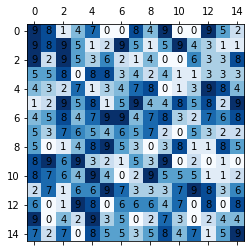

In [147]:
fig, ax = plt.subplots()

min_val, max_val = 0, 15

intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))

ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

for i in range(15):
    for j in range(15):
        c = intersection_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')